In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib import ticker
from cmaqpy.runcmaq import CMAQModel
import cmaqpy.prepemis as emis

In [7]:
# Read in the dispatch data file
gen_df = pd.read_csv(f'../cmaqpy/data/ny_emis/ed_output/thermal_with_renewable_20160805_20160815.csv', index_col=0, parse_dates=True)
gen_da = gen_df.sum(axis=1)

# Read in the solar data file
solar_df = pd.read_csv(f'/share/mzhang/jas983/wrf_data/wrf2power/data/solar_gen_d02_2016-08-05_00:00:00.csv', index_col=0)
solar_df = solar_df.drop(columns=['latitude', 'longitude'])
solar_da = solar_df.sum()
# Converting the index as date
solar_da.index = pd.to_datetime(solar_da.index)
# Converting from W to MW
solar_da = solar_da/(10 ** 6)

# Read in the wind data file
wind_df = pd.read_csv(f'/share/mzhang/jas983/wrf_data/wrf2power/data/wind_gen_d02_2016-08-05_00:00:00.csv', index_col=0, parse_dates=True)
wind_da = wind_df.sum(axis=1)
# Converting from kW to MW
wind_da = wind_da/(10 ** 3)

<AxesSubplot:ylabel='Solar Generation (MW)'>

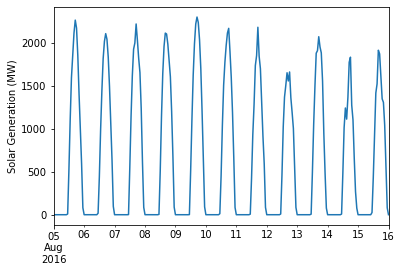

In [8]:
solar_da.plot(ylabel='Solar Generation (MW)')

<AxesSubplot:xlabel='Time', ylabel='Wind Generation (MW)'>

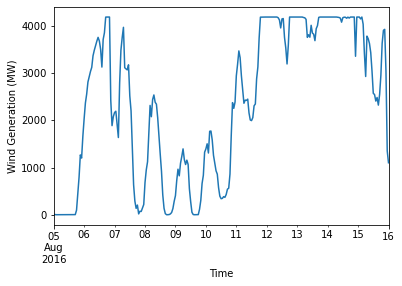

In [9]:
wind_da.plot(ylabel='Wind Generation (MW)')

<AxesSubplot:xlabel='TimeStamp', ylabel='Fossil Generation (MW)'>

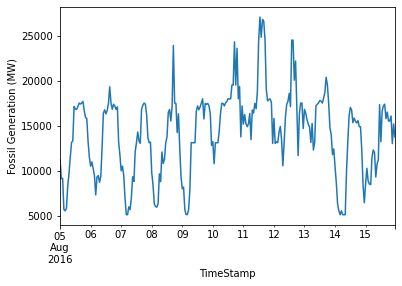

In [10]:
gen_da.plot(ylabel='Fossil Generation (MW)')

<AxesSubplot:ylabel='Added Renewables Fraction (%)'>

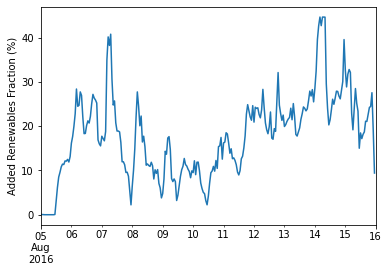

In [11]:
ren_frac = (solar_da + wind_da)/(solar_da + wind_da + gen_da) * 100
ren_frac.plot(ylabel='Added Renewables Fraction (%)')

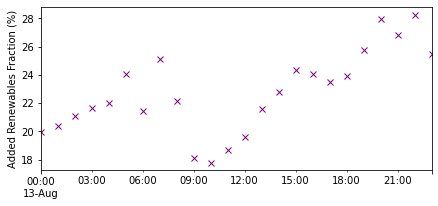

In [12]:
date='2016-08-13'
plot_df = ren_frac.loc[pd.Timestamp(f'{date} 00'):pd.Timestamp(f'{date} 23')]

f = plt.figure(figsize=(7,3))
p = plot_df.plot(color=['purple'], linewidth=2, style=['x'], ax=f.gca())
# plt.title(f'{ed_gen["NYISO Name"][gen_idx]}')
plt.ylabel('Added Renewables Fraction (%)')
# plt.savefig(f'../cmaqpy/data/plots/ren_frac_{date}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [13]:
# Read in NY Simple Net generation
gen_file = '../cmaqpy/data/ny_emis/ed_output/thermal_with_renewable_20160805_20160815.csv'
gen_base_file = '../cmaqpy/data/ny_emis/ed_output/thermal_without_renewable_20160805_20160815.csv'
lu_file = '../cmaqpy/data/ny_emis/ed_output/RGGI_to_NYISO.csv'
ed_gen = emis.fmt_like_camd(data_file=gen_file, lu_file=lu_file)
ed_gen_base = emis.fmt_like_camd(data_file=gen_base_file, lu_file=lu_file)

In [16]:
def gen_and_ren_frac(gen_idx, gen_df1, gen_df2, ren_frac_df, date=None, column_names=['Base Case', 'w/ Renewables'],
               figsize=(7,7), colors=['purple','orange'], linewidth=2, linestyles=['-','-.'], 
               titlestr1='(baseload/load following)', ylabelstr1='Power (MW)', ylabelstr2='Added Renewables Fraction (%)', 
               savefig=False, outfile_pfix='../cmaqpy/data/plots/gen_profs_'):

    """
    Compares changes in generation or emissions for two user-specified units.
    """
    if date is None:
        change_df1 = pd.concat([gen_df1.iloc[gen_idx,5:], gen_df2.iloc[gen_idx,5:]], axis=1)
    else:
        change_df1 = pd.concat([gen_df1.loc[gen_idx,pd.Timestamp(f'{date} 00'):pd.Timestamp(f'{date} 23')], gen_df2.loc[gen_idx,pd.Timestamp(f'{date} 00'):pd.Timestamp(f'{date} 23')]], axis=1)
    change_df1.columns = column_names
    # Converting the index as date
    change_df1.index = pd.to_datetime(change_df1.index)
    
    ren_frac_df = ren_frac_df.loc[pd.Timestamp(f'{date} 00'):pd.Timestamp(f'{date} 23')]

    _, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize)
    change_df1.plot(color=colors, linewidth=linewidth, style=linestyles, ax=ax1)
    ren_frac_df.plot(color=colors[0], linewidth=linewidth, style=['x'], ax=ax2)

    # ax2.get_legend().remove()
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=2)
    # ax1.legend(loc='lower center', ncol=2)
    ax1.set_title(f'{gen_df1["NYISO Name"][gen_idx]} {titlestr1}')
    # ax2.set_title(f'{gen_df1["NYISO Name"][gen_idx2]} {titlestr2}')
    ax1.set_ylabel(ylabelstr1)
    ax2.set_ylabel(ylabelstr2)
    if savefig:
        plt.savefig(f'{outfile_pfix}{gen_df1["NYISO Name"][gen_idx]}.png', dpi=300, transparent=True, bbox_inches='tight')
    else:
        plt.show()

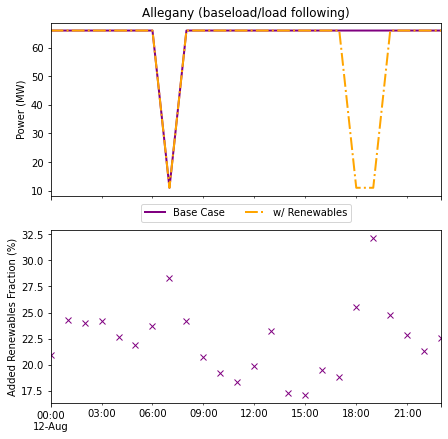

In [17]:
gen_and_ren_frac(2, ed_gen_base, ed_gen, ren_frac, date='2016-08-12', column_names=['Base Case', 'w/ Renewables'],
               figsize=(7,7), colors=['purple','orange'], linewidth=2, linestyles=['-','-.'], 
               titlestr1='(baseload/load following)', ylabelstr1='Power (MW)', ylabelstr2='Added Renewables Fraction (%)', 
               savefig=True, outfile_pfix='../cmaqpy/data/plots/gen_ren_frac_')